In [1]:
import argparse
from datetime import datetime
import math
import numpy as np
import pandas as pd
import time
import torch


from fireworks import LaunchPad
from jobflow import JobStore
from jobflow.managers.fireworks import flow_to_workflow
from maggma.stores.mongolike import MongoStore
from NanoParticleTools.flows.flows import get_npmc_flow
from NanoParticleTools.inputs.nanoparticle import SphericalConstraint
import uuid

from botorch.models import SingleTaskGP, ModelListGP
from botorch import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.optim import optimize_acqf

from common import seed_generator, configs

from common.utils import get_int, get_qe
from common import utils


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
def get_data_botorch(data_file, from_cloud = True):
    if from_cloud:
        df = gcloud_utils.get_df_gspread(GSPREAD_CRED, GSPREAD_NAME)
        #df = df.drop(labels=range(1, 600), axis=0)
        my_data = df.to_numpy()
        print(f"reading data log from google sheet: {GSPREAD_NAME}!")
    else:
        my_data = np.loadtxt(data_file, delimiter=',', skiprows=1)
        print(f"reading data log from local: {data_file}!")

    # features
    train_x = torch.from_numpy(my_data[:, :5])
    # labels
    train_y = torch.from_numpy(my_data[:, 5]).unsqueeze(-1)
    # best observation
    best_y = train_y.max().item()
    
    return train_x, train_y, best_y


def encode_inputs(x_arr, x_max = 34):
    '''encode simulation input to botorch'''
    for i, arr in enumerate(x_arr):
        x_arr[i, 0] = arr[0] + arr[1]
        if arr[0] + arr[1] == 0:
            x_arr[i, 1] = 0.5
        else:
            x_arr[i, 1] = arr[0] / (arr[0] + arr[1])
        x_arr[i, 2] = arr[2] + arr[3]
        if arr[2] + arr[3] == 0:
            x_arr[i, 3] = 0.5
        else:
            x_arr[i, 3] = arr[2] / (arr[2] + arr[3])
        x_arr[i, 4] = arr[4] / x_max


def decode_candidates(x_arr, x_max = 34):
    '''decode botorch recommendation candidates for simulation'''
    for i, arr in enumerate(x_arr):
        x_arr[i, 0], x_arr[i, 1] = arr[0] * arr[1], arr[0] * (1 - arr[1])
        x_arr[i, 2], x_arr[i, 3] = arr[2] * arr[3], arr[2] * (1 - arr[3])
        x_arr[i, 4] = arr[4] * x_max

def recommend(train_x, train_y, best_y, bounds, n_trails = 5):
    if isinstance(bounds, list):
        bounds = torch.tensor(bounds)
    elif torch.is_tensor(bounds):
        pass
    else:
        raise TypeError(f"expect bounds in a list or tensor. was given {type(bounds)}")
    
    single_model = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    
    # Expected Improvement acquisition function
    EI = qExpectedImprovement(model = single_model, best_f = best_y)
    # Upper Confidence Bound acquisition function
    UCB = UpperConfidenceBound(single_model, beta=100)
    
    # hyperparameters are super sensitive here
    candidates, _ = optimize_acqf(acq_function = UCB,
                                 bounds = bounds, 
                                 q = n_trails, 
                                 num_restarts = 20, 
                                 raw_samples = 512, 
                                # options = {'batch_limit': 5, "maxiter": 200}
                                 )
    
    return candidates
# New functions for pool-based AL. Different from real-test AL.

# recommend the next NP from the pool
def recommend_next(train_X,train_Y,test_X, beta):
    single_model = SingleTaskGP(train_X,train_Y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    UCB = UpperConfidenceBound(single_model, beta)

    ucb = UCB(torch.unsqueeze(test_X,1))
    max_idx = np.argmax(ucb.detach().numpy())
    max_ucb = max(ucb.detach().numpy())
    if max_ucb != ucb.detach().numpy()[max_idx]:
        print('wrong index')
    return max_idx, test_X[max_idx], test_y[max_idx]
    
# log results to csv
def log_result(test_X,test_Y,max_idx,data_dest):
    decode_candidates(test_X)
    features = test_X[max_idx].numpy()
    obs = test_Y[max_idx].numpy()
    df_features = pd.DataFrame(features.reshape(-1, len(features)))
    df_obs = pd.DataFrame(obs)
    df_log = pd.concat([df_features,df_obs],axis=1)
    df_log.columns =['yb_1', 'er_1', 'yb_2', 'er_2','radius','UV']
    log = pd.read_csv(data_dest)
    log = log.append(df_log, ignore_index=True)
    log.to_csv(data_dest, index=False)

# append results to a list
# test_X: features of a sample
# test_Y: obs of a sample
# max_idx: the index of the just evaluated sample in the pool
# log: the list to append results (test_X, test_Y, max_idx)
def append_result(test_X,test_Y,max_idx,log):
    decode_candidates(test_X)
    features = test_X[max_idx].numpy()
    obs = test_Y[max_idx].numpy()
    result = np.concatenate((features, obs), axis=None)
    log.append(result)
    
# update pool: removing the new recommended NP from the pool
def update_pool(train_X,train_Y,test_X,test_Y,pool_X, pool_Y, max_idx):
    train_X, train_Y = torch.cat([train_X,torch.unsqueeze(pool_X[max_idx],0)]),torch.cat([train_Y,torch.unsqueeze(pool_Y[max_idx],0)])
    #print(pool_x[max_idx])
    if max_idx ==0:
        pool_X, pool_Y = pool_X[1:], pool_y[1:]
    elif max_idx ==(len(pool_X)-1):
        pool_X, pool_Y = pool_X[:-1], pool_y[:-1]
    else:
        pool_X, pool_Y = torch.cat([pool_X[:max_idx], pool_X[max_idx+1:]]), torch.cat([pool_Y[0:max_idx], pool_Y[max_idx+1:]]),
    test_X, test_Y = torch.clone(pool_X), torch.clone(pool_Y)
    return train_X,train_Y,test_X,test_Y,pool_X, pool_Y

# plot the result of a speified pool-based study:
#      calculate the best obs at at each step and plot the trajectory;
#      return the final best obs value and steps to achieve the best
def add_one_ensemble(log_seed,i):
    df = pd.DataFrame((log_seed[i]))
    df.columns =['yb_1', 'er_1', 'yb_2', 'er_2','radius','UV']

    evalued = len(df)
    max_uv = []
    y = df.UV
    for i in range(evalued):
        max_uv.append(df.iloc[0:i+1].UV.max())
    x = range(len(max_uv))
    max_x = len(max_uv)
    max_y = max(max_uv)    
    ax1.scatter(x, y, c='black', alpha = 0.3)
    ax2.plot(x, max_uv, c='r', alpha = 1)
    return max_x, max_y

In [70]:
import random
from botorch.acquisition import UpperConfidenceBound

# Use this code if you want to specify the initial dataset saved under a directory
# init_x, init_y, _ = get_data_botorch("../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv", from_cloud=False)
# train_x, train_y = init_x[:10], init_y[:10]

# Use this code to generate random initial datasets by selecting different seed values
#seed=[0,1,4,5,6,7,8,9,13,15] # for 10-sample inits
seed=[0,1,2,3,4,5,6,7,8,9] # for 20-inits
#seed=[0,1,11,12,13,5,6,7,8,9] # for 40-inits
#seed=[100,1,101,3,101,5,6,7,102,9]  #for 80-inits

beta = 1e5
n_initial = 20

log_seed=[] # the list to save results of each iteration
# generate an empty list of list. Length  = seed counts = n trials
for s in seed:
    log_seed.append([])

count = 0 # to track how many trials have been done
for s in seed:
    print(f'initilizing seed {s}...')
    random.seed(s)
    # read pool from saved data
    pool_x, pool_y, _ = get_data_botorch("../saved_data/simulation_log_from_gsheet.csv", from_cloud=False)
    encode_inputs(pool_x)
    indices = list(np.arange(len(pool_x)))
    index_pool = indices.copy()

    # read 10 random samples from the pool
    index_ = random.sample(index_pool, n_initial)
    init_x, init_y = pool_x[index_], pool_y[index_]
    train_x, train_y = torch.clone(init_x), torch.clone(init_y)
    # remove the initial samples from the test pool
    test_indices = list(set(indices)-set(index_))
    pool_x, pool_y = pool_x[test_indices], pool_y[test_indices]
    test_x, test_y = torch.clone(pool_x), torch.clone(pool_y)

    # check the max obs in the pool. 
    # If max_obs smaller than the max in the original pool, the max sample is in the init samples. 
    print(max(pool_y))
    
    for i in range(len(pool_x)):
        max_idx, max_feature, max_obs = recommend_next(train_x,train_y,test_x, beta = beta)
        print(i, max_idx, len(train_x),len(test_x))
        append_result(test_x,test_y,max_idx,log_seed[count])

        if (test_y[max_idx] >= max(test_y)):
            print("reached best")
            print(test_y[max_idx])
            print(i)
            break
        train_x,train_y,test_x,test_y,pool_x, pool_y = update_pool(train_x,train_y,test_x,test_y,pool_x, pool_y, max_idx)
    count += 1

initilizing seed 0...
reading data log from local: ../saved_data/simulation_log_from_gsheet.csv!
tensor([9049.9994], dtype=torch.float64)
0 630 20 656
1 243 21 655
2 591 22 654
3 317 23 653
4 647 24 652
5 428 25 651
6 577 26 650
7 374 27 649
8 480 28 648
9 356 29 647
10 465 30 646
11 402 31 645
12 323 32 644
13 109 33 643
14 555 34 642
15 636 35 641
16 339 36 640
17 580 37 639
18 488 38 638
19 224 39 637
20 366 40 636
21 38 41 635
22 472 42 634
23 501 43 633
24 7 44 632
25 493 45 631
26 371 46 630
27 141 47 629
28 513 48 628
29 438 49 627
30 358 50 626
31 250 51 625
32 84 52 624
33 393 53 623
34 490 54 622
35 79 55 621
36 158 56 620
37 440 57 619
38 69 58 618
39 38 59 617
40 238 60 616
41 153 61 615
42 350 62 614
43 32 63 613
44 307 64 612
45 347 65 611
46 366 66 610
47 483 67 609
48 531 68 608
49 40 69 607
50 541 70 606
51 431 71 605
52 70 72 604
53 495 73 603
54 38 74 602
55 20 75 601
56 169 76 600
57 273 77 599
58 46 78 598
59 526 79 597
60 44 80 596
61 350 81 595
62 51 82 594
63 38

129 74 149 527
130 143 150 526
131 302 151 525
132 304 152 524
133 184 153 523
134 24 154 522
135 214 155 521
136 155 156 520
137 424 157 519
138 436 158 518
139 66 159 517
140 412 160 516
141 8 161 515
142 324 162 514
143 441 163 513
144 334 164 512
145 372 165 511
146 91 166 510
147 342 167 509
148 221 168 508
149 83 169 507
150 119 170 506
151 30 171 505
152 452 172 504
153 313 173 503
154 267 174 502
155 80 175 501
156 73 176 500
157 28 177 499
158 57 178 498
159 205 179 497
160 289 180 496
161 401 181 495
162 425 182 494
163 100 183 493
164 139 184 492
165 170 185 491
166 36 186 490
167 227 187 489
168 192 188 488
169 244 189 487
170 95 190 486
171 398 191 485
172 378 192 484
173 195 193 483
174 202 194 482
175 405 195 481
176 45 196 480
177 135 197 479
178 14 198 478
179 11 199 477
180 231 200 476
181 141 201 475
182 326 202 474
183 398 203 473
184 392 204 472
185 231 205 471
186 30 206 470
187 247 207 469
188 171 208 468
189 247 209 467
190 147 210 466
191 212 211 465
192 188 21

166 334 186 490
167 278 187 489
168 73 188 488
169 199 189 487
170 183 190 486
171 353 191 485
172 70 192 484
173 188 193 483
174 170 194 482
175 255 195 481
176 121 196 480
177 316 197 479
178 238 198 478
179 277 199 477
180 255 200 476
181 419 201 475
182 29 202 474
183 190 203 473
184 135 204 472
185 29 205 471
186 274 206 470
187 70 207 469
188 2 208 468
189 40 209 467
190 282 210 466
191 23 211 465
192 385 212 464
193 105 213 463
194 259 214 462
195 349 215 461
196 216 216 460
197 184 217 459
198 382 218 458
199 40 219 457
200 367 220 456
201 27 221 455
202 120 222 454
203 219 223 453
204 12 224 452
205 239 225 451
206 13 226 450
207 187 227 449
208 319 228 448
209 124 229 447
210 18 230 446
211 274 231 445
212 80 232 444
213 369 233 443
214 182 234 442
215 319 235 441
216 282 236 440
217 286 237 439
218 244 238 438
219 38 239 437
220 205 240 436
221 309 241 435
222 243 242 434
223 145 243 433
224 188 244 432
225 269 245 431
226 274 246 430
227 363 247 429
228 242 248 428
229 160 

339 111 359 317
340 254 360 316
341 245 361 315
342 21 362 314
343 24 363 313
344 94 364 312
345 221 365 311
346 56 366 310
347 44 367 309
348 120 368 308
349 72 369 307
350 211 370 306
351 166 371 305
352 242 372 304
353 96 373 303
354 142 374 302
355 192 375 301
356 116 376 300
357 225 377 299
358 160 378 298
359 112 379 297
360 184 380 296
361 189 381 295
362 185 382 294
363 173 383 293
364 159 384 292
365 98 385 291
366 46 386 290
367 52 387 289
368 6 388 288
369 186 389 287
370 218 390 286
371 136 391 285
372 58 392 284
373 23 393 283
374 143 394 282
375 207 395 281
376 91 396 280
377 182 397 279
378 92 398 278
379 159 399 277
380 81 400 276
381 163 401 275
382 190 402 274
383 65 403 273
384 159 404 272
385 218 405 271
386 110 406 270
387 178 407 269
388 151 408 268
389 203 409 267
390 91 410 266
391 156 411 265
392 210 412 264
393 212 413 263
reached best
tensor([9049.9994], dtype=torch.float64)
393
initilizing seed 7...
reading data log from local: ../saved_data/simulation_log_f

71 410 91 585
72 463 92 584
73 60 93 583
74 465 94 582
75 438 95 581
76 273 96 580
77 300 97 579
78 427 98 578
79 378 99 577
80 349 100 576
81 343 101 575
82 0 102 574
83 34 103 573
84 357 104 572
85 509 105 571
86 220 106 570
87 72 107 569
88 268 108 568
89 464 109 567
90 363 110 566
91 230 111 565
92 377 112 564
93 370 113 563
94 278 114 562
95 341 115 561
96 117 116 560
97 126 117 559
98 10 118 558
99 257 119 557
100 355 120 556
101 231 121 555
102 339 122 554
103 365 123 553
104 231 124 552
105 282 125 551
106 26 126 550
107 4 127 549
108 29 128 548
109 431 129 547
110 33 130 546
111 466 131 545
112 444 132 544
113 19 133 543
114 73 134 542
115 377 135 541
116 155 136 540
117 427 137 539
118 331 138 538
119 39 139 537
120 325 140 536
121 281 141 535
122 380 142 534
123 324 143 533
124 115 144 532
125 438 145 531
126 78 146 530
127 392 147 529
128 347 148 528
129 32 149 527
130 32 150 526
131 337 151 525
132 74 152 524
133 267 153 523
134 52 154 522
135 7 155 521
136 56 156 520
137 

109 51 129 547
110 323 130 546
111 36 131 545
112 393 132 544
113 276 133 543
114 218 134 542
115 475 135 541
116 278 136 540
117 118 137 539
118 266 138 538
119 400 139 537
120 34 140 536
121 314 141 535
122 17 142 534
123 329 143 533
124 23 144 532
125 0 145 531
126 90 146 530
127 416 147 529
128 374 148 528
129 101 149 527
130 57 150 526
131 463 151 525
132 372 152 524
133 11 153 523
134 370 154 522
135 305 155 521
136 13 156 520
137 116 157 519
138 26 158 518
139 128 159 517
140 305 160 516
141 214 161 515
142 254 162 514
143 294 163 513
144 76 164 512
145 196 165 511
146 134 166 510
147 6 167 509
148 363 168 508
149 102 169 507
150 209 170 506
151 271 171 505
152 290 172 504
153 161 173 503
154 446 174 502
155 394 175 501
156 229 176 500
157 353 177 499
158 399 178 498
159 333 179 497
160 114 180 496
161 379 181 495
162 192 182 494
163 422 183 493
164 26 184 492
165 246 185 491
166 235 186 490
167 83 187 489
168 385 188 488
169 287 189 487
170 242 190 486
171 63 191 485
172 239 19

In [33]:
# use this one for trouble shooting
# sometimes the selected random seed results in max_obs in the initial dataset. Need a new seed.
# change the seed list and count value
# check beta values

seed=[13,5,6,7,8,9]
count = 4
beta = 100000
log_seed[count]=[]
for s in seed:
    print(f'initilizing seed {s}...')
    random.seed(s)
    # read pool from saved data
    pool_x, pool_y, _ = get_data_botorch("../saved_data/simulation_log_from_gsheet.csv", from_cloud=False)
    encode_inputs(pool_x)
    indices = list(np.arange(len(pool_x)))
    index_pool = indices.copy()

    # read 10 random samples from the pool
    index_ = random.sample(index_pool, n_initial)
    init_x, init_y = pool_x[index_], pool_y[index_]
    train_x, train_y = torch.clone(init_x), torch.clone(init_y)
    test_indices = list(set(indices)-set(index_))
    pool_x, pool_y = pool_x[test_indices], pool_y[test_indices]
    test_x, test_y = torch.clone(pool_x), torch.clone(pool_y)

    # check the max obs in the pool
    print(max(pool_y))
    
    for i in range(len(pool_x)):
    #for i in range(3):
        max_idx, max_feature, max_obs = recommend_next(train_x,train_y,test_x, beta=beta)
        print(i, max_idx, len(train_x),len(test_x))
        print(max_feature)
        #log_result(test_x,test_y,max_idx,DATA_DEST)
        append_result(test_x,test_y,max_idx,log_seed[count])

        if (test_y[max_idx] >= max(test_y)):
            print("reached best")
            print(test_y[max_idx])
            print(i)
            break
        train_x,train_y,test_x,test_y,pool_x, pool_y = update_pool(train_x,train_y,test_x,test_y,pool_x, pool_y, max_idx)
    count += 1

initilizing seed 13...
reading data log from local: ../saved_data/simulation_log_from_gsheet.csv!
tensor([9049.9994], dtype=torch.float64)
0 447 40 636
tensor([0.1918, 0.7592, 0.9921, 0.9432, 0.0501], dtype=torch.float64)
1 472 41 635
tensor([0.6887, 0.8186, 0.2349, 0.7668, 0.1580], dtype=torch.float64)
2 18 42 634
tensor([0.0000, 0.5000, 0.9757, 0.5329, 0.2876], dtype=torch.float64)
3 106 43 633
tensor([0.8611, 0.5117, 0.0029, 0.9790, 0.2758], dtype=torch.float64)
4 423 44 632
tensor([0.5272, 0.5106, 0.0096, 0.5256, 0.0664], dtype=torch.float64)
5 449 45 631
tensor([0.0441, 0.9288, 0.9441, 0.5334, 0.2304], dtype=torch.float64)
6 82 46 630
tensor([0.7435, 0.5082, 0.9526, 0.8568, 0.1718], dtype=torch.float64)
7 37 47 629
tensor([0.0000, 0.5000, 0.9589, 0.7877, 0.9229], dtype=torch.float64)
8 308 48 628
tensor([0.9925, 0.6500, 0.9248, 0.5448, 0.2524], dtype=torch.float64)
9 455 49 627
tensor([0.2379, 0.8409, 0.8223, 0.9726, 0.4262], dtype=torch.float64)
10 138 50 626
tensor([0.1797, 0.63

96 367 136 540
tensor([0.0793, 0.7554, 0.1556, 0.6548, 0.7908], dtype=torch.float64)
97 252 137 539
tensor([0.4865, 0.8862, 0.7392, 0.5858, 0.2355], dtype=torch.float64)
98 314 138 538
tensor([0.9785, 0.8372, 0.2669, 0.6772, 0.8562], dtype=torch.float64)
99 359 139 537
tensor([0.5795, 0.5157, 0.3345, 0.7735, 0.7111], dtype=torch.float64)
100 4 140 536
tensor([0.0000, 0.5000, 0.0419, 0.7323, 0.9247], dtype=torch.float64)
101 301 141 535
tensor([0.9005, 0.7859, 0.4644, 0.5339, 0.2600], dtype=torch.float64)
102 366 142 534
tensor([0.3838, 0.5650, 0.5493, 0.5492, 0.7586], dtype=torch.float64)
103 23 143 533
tensor([0.0000, 0.5000, 0.8296, 0.7525, 0.5840], dtype=torch.float64)
104 268 144 532
tensor([0.5500, 0.9035, 0.7718, 0.5333, 0.9653], dtype=torch.float64)
105 84 145 531
tensor([0.6339, 0.5162, 0.4235, 0.7499, 0.3172], dtype=torch.float64)
106 20 146 530
tensor([0.0000, 0.5000, 0.4361, 0.9440, 0.8298], dtype=torch.float64)
107 336 147 529
tensor([0.3929, 0.5046, 0.6779, 0.7429, 0.3959]

192 5 232 444
tensor([0.0000, 0.5000, 0.2845, 0.5431, 0.4847], dtype=torch.float64)
193 371 233 443
tensor([0.0065, 0.8475, 0.6236, 0.6310, 0.5539], dtype=torch.float64)
194 246 234 442
tensor([0.8897, 0.8104, 0.1492, 0.5714, 0.6967], dtype=torch.float64)
195 353 235 441
tensor([0.3211, 0.6714, 0.5348, 0.6583, 0.3948], dtype=torch.float64)
196 368 236 440
tensor([0.1733, 0.7107, 0.1674, 0.5045, 0.3978], dtype=torch.float64)
197 46 237 439
tensor([0.0463, 0.6603, 0.2203, 0.5082, 0.8939], dtype=torch.float64)
198 73 238 438
tensor([0.6259, 0.5215, 0.8213, 0.5176, 0.7317], dtype=torch.float64)
199 162 239 437
tensor([0.3730, 0.7663, 0.8409, 0.8218, 0.2233], dtype=torch.float64)
200 195 240 436
tensor([0.5458, 0.7616, 0.6903, 0.9323, 0.5696], dtype=torch.float64)
201 38 241 435
tensor([0.0414, 0.6366, 0.6971, 0.6159, 0.2345], dtype=torch.float64)
202 226 242 434
tensor([0.8134, 0.7726, 0.2594, 0.9239, 0.5101], dtype=torch.float64)
203 173 243 433
tensor([0.6060, 0.6771, 0.3982, 0.5253, 0.2

288 72 328 348
tensor([0.2942, 0.5846, 0.7608, 0.5884, 0.6519], dtype=torch.float64)
289 154 329 347
tensor([0.7482, 0.6880, 0.0000, 0.5000, 0.6175], dtype=torch.float64)
290 113 330 346
tensor([0.2155, 0.9510, 0.0194, 0.8064, 0.3347], dtype=torch.float64)
291 257 331 345
tensor([0.7375, 0.6816, 0.5330, 0.6873, 0.5147], dtype=torch.float64)
292 183 332 344
tensor([0.8897, 0.8026, 0.9498, 0.5950, 0.4018], dtype=torch.float64)
293 188 333 343
tensor([0.9289, 0.5476, 0.9414, 0.6455, 0.1667], dtype=torch.float64)
294 102 334 342
tensor([0.3662, 0.6540, 0.1108, 0.9095, 0.2031], dtype=torch.float64)
295 251 335 341
tensor([0.1275, 0.9478, 0.6712, 0.9223, 0.2922], dtype=torch.float64)
296 147 336 340
tensor([0.4548, 0.8528, 0.4453, 0.6517, 0.3634], dtype=torch.float64)
297 127 337 339
tensor([0.3628, 0.8512, 0.7523, 0.7248, 0.5604], dtype=torch.float64)
298 156 338 338
tensor([0.7542, 0.7099, 0.4406, 0.7623, 0.7992], dtype=torch.float64)
299 201 339 337
tensor([0.2182, 0.6716, 0.0279, 0.9284,

11 546 51 625
tensor([0.2840, 0.9831, 0.8587, 0.5940, 0.9950], dtype=torch.float64)
12 448 52 624
tensor([0.8301, 0.5037, 0.6017, 0.8360, 0.5505], dtype=torch.float64)
13 369 53 623
tensor([0.9814, 0.9561, 0.7295, 0.6392, 0.9529], dtype=torch.float64)
14 511 54 622
tensor([0.8597, 0.9272, 0.3754, 0.9366, 0.0453], dtype=torch.float64)
15 226 55 621
tensor([0.2697, 0.9144, 0.0000, 0.5000, 0.9762], dtype=torch.float64)
16 487 56 620
tensor([0.1275, 0.9478, 0.6712, 0.9223, 0.2922], dtype=torch.float64)
17 372 57 619
tensor([0.9388, 0.5277, 0.4291, 0.9054, 0.9637], dtype=torch.float64)
18 233 58 618
tensor([0.2727, 0.9721, 0.2515, 0.7295, 0.2393], dtype=torch.float64)
19 107 59 617
tensor([0.4095, 0.5283, 0.9826, 0.6439, 0.8930], dtype=torch.float64)
20 80 60 616
tensor([0.7435, 0.5082, 0.9526, 0.8568, 0.1718], dtype=torch.float64)
21 452 61 615
tensor([0.9982, 0.5657, 0.1921, 0.5785, 0.9943], dtype=torch.float64)
22 399 62 614
tensor([0.6550, 0.9999, 0.9029, 0.6853, 0.6140], dtype=torch.fl

109 443 149 527
tensor([0.2843, 0.7923, 0.0143, 0.5347, 0.7232], dtype=torch.float64)
110 422 150 526
tensor([0.5936, 0.7900, 0.7471, 0.6359, 0.2672], dtype=torch.float64)
111 16 151 525
tensor([0.0000, 0.5000, 0.7155, 0.5681, 0.3956], dtype=torch.float64)
112 295 152 524
tensor([0.9005, 0.7859, 0.4644, 0.5339, 0.2600], dtype=torch.float64)
113 264 153 523
tensor([0.8598, 0.7077, 0.7501, 0.5066, 0.7364], dtype=torch.float64)
114 457 154 522
tensor([0.1291, 0.9050, 0.8058, 0.7594, 0.9718], dtype=torch.float64)
115 179 155 521
tensor([0.2536, 0.8698, 0.5375, 0.5954, 0.8277], dtype=torch.float64)
116 65 156 520
tensor([0.3093, 0.5263, 0.2741, 0.5537, 0.7036], dtype=torch.float64)
117 141 157 519
tensor([0.1616, 0.8997, 0.1570, 0.5923, 0.3079], dtype=torch.float64)
118 405 158 518
tensor([0.4114, 0.5003, 0.7736, 0.6313, 0.0668], dtype=torch.float64)
119 200 159 517
tensor([0.4317, 0.7666, 0.0829, 0.5238, 0.9286], dtype=torch.float64)
120 357 160 516
tensor([0.9901, 0.5651, 0.1833, 0.6322, 

205 141 245 431
tensor([0.2382, 0.8662, 0.3112, 0.7314, 0.2245], dtype=torch.float64)
206 241 246 430
tensor([0.8183, 0.9246, 0.8320, 0.6516, 0.3486], dtype=torch.float64)
207 342 247 429
tensor([0.0846, 0.7190, 0.4775, 0.5615, 0.3462], dtype=torch.float64)
208 224 248 428
tensor([0.6914, 0.8490, 0.8913, 0.9714, 0.1858], dtype=torch.float64)
209 64 249 427
tensor([0.6339, 0.5162, 0.4235, 0.7499, 0.3172], dtype=torch.float64)
210 183 250 426
tensor([0.4222, 0.8837, 0.7992, 0.5123, 0.7514], dtype=torch.float64)
211 171 251 425
tensor([0.8557, 0.6177, 0.1672, 0.8375, 0.3489], dtype=torch.float64)
212 201 252 424
tensor([0.7919, 0.6939, 0.8673, 0.6317, 0.6140], dtype=torch.float64)
213 192 253 423
tensor([0.4865, 0.8862, 0.7392, 0.5858, 0.2355], dtype=torch.float64)
214 102 254 422
tensor([0.6797, 0.5425, 0.1705, 0.6497, 0.9776], dtype=torch.float64)
215 23 255 421
tensor([0.0160, 0.6002, 0.5048, 0.9068, 0.7228], dtype=torch.float64)
216 251 256 420
tensor([0.1057, 0.7728, 0.0209, 0.5629, 

8 375 48 628
tensor([0.8360, 0.9684, 0.3357, 0.7257, 0.3330], dtype=torch.float64)
9 47 49 627
tensor([0.0034, 0.9468, 0.0013, 0.8562, 0.8674], dtype=torch.float64)
10 574 50 626
tensor([0.6491, 0.9605, 0.0000, 0.5000, 0.6339], dtype=torch.float64)
11 499 51 625
tensor([0.6001, 0.5340, 0.6307, 0.7624, 0.0285], dtype=torch.float64)
12 24 52 624
tensor([0.0000, 0.5000, 0.8831, 0.5749, 0.1625], dtype=torch.float64)
13 364 53 623
tensor([0.8972, 0.8465, 0.9683, 0.7344, 0.3364], dtype=torch.float64)
14 4 54 622
tensor([0.0000, 0.5000, 0.0600, 0.5625, 0.1547], dtype=torch.float64)
15 78 55 621
tensor([0.5686, 0.5107, 0.4695, 0.5750, 0.5191], dtype=torch.float64)
16 243 56 620
tensor([0.2810, 0.9934, 0.3206, 0.5513, 0.1508], dtype=torch.float64)
17 29 57 619
tensor([0.0000, 0.5000, 0.4361, 0.9440, 0.8298], dtype=torch.float64)
18 448 58 618
tensor([0.1540, 0.5359, 0.6335, 0.5206, 0.0312], dtype=torch.float64)
19 488 59 617
tensor([0.6551, 0.9873, 0.9909, 0.6940, 0.1363], dtype=torch.float64)


106 42 146 530
tensor([0.0526, 0.5503, 0.5164, 0.5834, 0.2732], dtype=torch.float64)
107 359 147 529
tensor([0.4590, 0.6304, 0.9842, 0.7737, 0.5033], dtype=torch.float64)
108 308 148 528
tensor([0.7632, 0.9447, 0.8905, 0.5996, 0.2348], dtype=torch.float64)
109 186 149 527
tensor([0.3237, 0.7484, 0.4897, 0.6045, 0.9027], dtype=torch.float64)
110 328 150 526
tensor([0.6013, 0.7100, 0.1747, 0.5196, 0.8237], dtype=torch.float64)
111 332 151 525
tensor([0.1057, 0.7728, 0.0209, 0.5629, 0.2609], dtype=torch.float64)
112 440 152 524
tensor([0.9916, 0.5520, 0.3746, 0.7883, 0.6782], dtype=torch.float64)
113 144 153 523
tensor([0.1386, 0.8839, 0.5006, 0.8921, 0.3642], dtype=torch.float64)
114 334 154 522
tensor([0.5206, 0.5997, 0.4966, 0.8117, 0.3654], dtype=torch.float64)
115 137 155 521
tensor([0.7915, 0.5382, 0.8919, 0.5584, 0.3969], dtype=torch.float64)
116 116 156 520
tensor([0.1327, 0.7293, 0.9059, 0.8041, 0.6833], dtype=torch.float64)
117 440 157 519
tensor([0.8345, 0.9631, 0.2201, 0.6721,

202 356 242 434
tensor([0.5213, 0.6209, 0.3980, 0.7048, 0.1077], dtype=torch.float64)
203 226 243 433
tensor([0.5941, 0.9281, 0.4582, 0.8952, 0.1831], dtype=torch.float64)
204 311 244 432
tensor([0.3979, 0.5015, 0.6779, 0.6457, 0.8838], dtype=torch.float64)
205 334 245 431
tensor([0.1757, 0.5295, 0.0325, 0.5259, 0.1643], dtype=torch.float64)
206 239 246 430
tensor([0.7840, 0.8202, 0.3107, 0.5453, 0.2664], dtype=torch.float64)
207 208 247 429
tensor([0.7919, 0.6939, 0.8673, 0.6317, 0.6140], dtype=torch.float64)
208 149 248 428
tensor([0.2536, 0.8698, 0.5375, 0.5954, 0.8277], dtype=torch.float64)
209 271 249 427
tensor([0.7850, 0.5246, 0.7551, 0.5610, 0.2330], dtype=torch.float64)
210 334 250 426
tensor([0.7039, 0.7188, 0.3404, 0.8131, 0.7165], dtype=torch.float64)
211 227 251 425
tensor([0.8894, 0.7387, 0.0000, 0.5000, 0.8107], dtype=torch.float64)
212 265 252 424
tensor([0.6586, 0.6548, 0.2293, 0.5499, 0.1438], dtype=torch.float64)
213 350 253 423
tensor([0.1473, 0.6447, 0.5109, 0.7585

298 119 338 338
tensor([0.7998, 0.5929, 0.0000, 0.5000, 0.8663], dtype=torch.float64)
299 336 339 337
tensor([0.7306, 0.9948, 0.0000, 0.5000, 0.6528], dtype=torch.float64)
300 113 340 336
tensor([0.3089, 0.8111, 0.2506, 0.5328, 0.5213], dtype=torch.float64)
301 180 341 335
tensor([0.2885, 0.6286, 0.9872, 0.6215, 0.4139], dtype=torch.float64)
302 72 342 334
tensor([0.1270, 0.7987, 0.0144, 0.6360, 0.6314], dtype=torch.float64)
303 114 343 333
tensor([0.2609, 0.9416, 0.7141, 0.8928, 0.7908], dtype=torch.float64)
304 29 344 332
tensor([0.0271, 0.8037, 0.8438, 0.7061, 0.2967], dtype=torch.float64)
305 202 345 331
tensor([0.3235, 0.8398, 0.4738, 0.6124, 0.1783], dtype=torch.float64)
306 224 346 330
tensor([0.4589, 0.6061, 0.1967, 0.7242, 0.7406], dtype=torch.float64)
307 268 347 329
tensor([0.3159, 0.9761, 0.3970, 0.9270, 0.7999], dtype=torch.float64)
308 94 348 328
tensor([0.3662, 0.6540, 0.1108, 0.9095, 0.2031], dtype=torch.float64)
309 163 349 327
tensor([0.7010, 0.8627, 0.5786, 0.9559, 0

394 2 434 242
tensor([0.0000, 0.5000, 0.2485, 0.5582, 0.9173], dtype=torch.float64)
395 161 435 241
tensor([0.7691, 0.6417, 0.6967, 0.9953, 0.2426], dtype=torch.float64)
396 22 436 240
tensor([0.0619, 0.6468, 0.0156, 0.8749, 0.2446], dtype=torch.float64)
397 60 437 239
tensor([0.2220, 0.6973, 0.6628, 0.6716, 0.6621], dtype=torch.float64)
398 92 438 238
tensor([0.4694, 0.8084, 0.4107, 0.5254, 0.5006], dtype=torch.float64)
399 145 439 237
tensor([0.0627, 0.5939, 0.1703, 0.6402, 0.5866], dtype=torch.float64)
400 87 440 236
tensor([0.4356, 0.7891, 0.1335, 0.6629, 0.8387], dtype=torch.float64)
401 120 441 235
tensor([0.8584, 0.9022, 0.0749, 0.8184, 0.8553], dtype=torch.float64)
402 64 442 234
tensor([0.3270, 0.6688, 0.2424, 0.6532, 0.9701], dtype=torch.float64)
403 118 443 233
tensor([0.7485, 0.8636, 0.9283, 0.6275, 0.3428], dtype=torch.float64)
404 168 444 232
tensor([0.1129, 0.7297, 0.7932, 0.6173, 0.5312], dtype=torch.float64)
405 169 445 231
tensor([0.6272, 0.8941, 0.4631, 0.6331, 0.431

12 565 52 624
tensor([0.0628, 0.7513, 0.9418, 0.5878, 0.9711], dtype=torch.float64)
13 341 53 623
tensor([0.9900, 0.7173, 0.0038, 0.6964, 0.1563], dtype=torch.float64)
14 4 54 622
tensor([0.0000, 0.5000, 0.0600, 0.5625, 0.1547], dtype=torch.float64)
15 15 55 621
tensor([0.0000, 0.5000, 0.9961, 0.5272, 0.5798], dtype=torch.float64)
16 365 56 620
tensor([0.9542, 0.8422, 0.6433, 0.6160, 0.2781], dtype=torch.float64)
17 352 57 619
tensor([0.9628, 0.7611, 0.9671, 0.6300, 0.7377], dtype=torch.float64)
18 130 58 618
tensor([0.0821, 0.8939, 0.6105, 0.7366, 0.9871], dtype=torch.float64)
19 510 59 617
tensor([0.8597, 0.9272, 0.3754, 0.9366, 0.0453], dtype=torch.float64)
20 425 60 616
tensor([0.8087, 0.5108, 0.6779, 0.8495, 0.1652], dtype=torch.float64)
21 44 61 615
tensor([0.0034, 0.9468, 0.0013, 0.8562, 0.8674], dtype=torch.float64)
22 550 62 614
tensor([0.0674, 0.6720, 0.3507, 0.8833, 0.0179], dtype=torch.float64)
23 226 63 613
tensor([0.7998, 0.5929, 0.0000, 0.5000, 0.8663], dtype=torch.float

110 140 150 526
tensor([0.1386, 0.8839, 0.5006, 0.8921, 0.3642], dtype=torch.float64)
111 262 151 525
tensor([0.9925, 0.6500, 0.9248, 0.5448, 0.2524], dtype=torch.float64)
112 308 152 524
tensor([0.8308, 0.9104, 0.5657, 0.7869, 0.4659], dtype=torch.float64)
113 203 153 523
tensor([0.3097, 0.9598, 0.7470, 0.5240, 0.6882], dtype=torch.float64)
114 192 154 522
tensor([0.4535, 0.6903, 0.0000, 0.5000, 0.6998], dtype=torch.float64)
115 3 155 521
tensor([0.0000, 0.5000, 0.1099, 0.5442, 0.9693], dtype=torch.float64)
116 382 156 520
tensor([0.9990, 0.6134, 0.1112, 0.5015, 0.9270], dtype=torch.float64)
117 299 157 519
tensor([0.9073, 0.7902, 0.3942, 0.9494, 0.5175], dtype=torch.float64)
118 440 158 518
tensor([0.6809, 0.8124, 0.4883, 0.6057, 0.9609], dtype=torch.float64)
119 375 159 517
tensor([0.4138, 0.5152, 0.0949, 0.7707, 0.3940], dtype=torch.float64)
120 47 160 516
tensor([0.0310, 0.6836, 0.9571, 0.5067, 0.4242], dtype=torch.float64)
121 67 161 515
tensor([0.0616, 0.6994, 0.5566, 0.9486, 0.

206 155 246 430
tensor([0.8442, 0.5793, 0.2805, 0.6779, 0.5006], dtype=torch.float64)
207 263 247 429
tensor([0.1057, 0.7728, 0.0209, 0.5629, 0.2609], dtype=torch.float64)
208 27 248 428
tensor([0.1562, 0.5156, 0.9993, 0.6422, 0.6082], dtype=torch.float64)
209 239 249 427
tensor([0.7840, 0.8202, 0.3107, 0.5453, 0.2664], dtype=torch.float64)
210 219 250 426
tensor([0.8598, 0.7077, 0.7501, 0.5066, 0.7364], dtype=torch.float64)
211 190 251 425
tensor([0.4222, 0.8837, 0.7992, 0.5123, 0.7514], dtype=torch.float64)
212 189 252 424
tensor([0.6656, 0.6879, 0.6173, 0.6798, 0.2203], dtype=torch.float64)
213 329 253 423
tensor([0.1757, 0.5295, 0.0325, 0.5259, 0.1643], dtype=torch.float64)
214 17 254 422
tensor([0.0000, 0.5000, 0.4615, 0.9653, 0.2790], dtype=torch.float64)
215 106 255 421
tensor([0.7915, 0.5382, 0.8919, 0.5584, 0.3969], dtype=torch.float64)
216 93 256 420
tensor([0.1270, 0.7987, 0.0144, 0.6360, 0.6314], dtype=torch.float64)
217 327 257 419
tensor([0.3082, 0.9814, 0.6308, 0.8335, 0

43 143 83 593
tensor([0.0982, 0.9501, 0.0000, 0.5000, 0.4688], dtype=torch.float64)
44 395 84 592
tensor([0.5272, 0.5106, 0.0096, 0.5256, 0.0664], dtype=torch.float64)
45 515 85 591
tensor([0.2840, 0.9831, 0.8587, 0.5940, 0.9950], dtype=torch.float64)
46 342 86 590
tensor([0.8485, 0.8735, 0.0000, 0.5000, 0.5194], dtype=torch.float64)
47 414 87 589
tensor([0.1918, 0.7592, 0.9921, 0.9432, 0.0501], dtype=torch.float64)
48 526 88 588
tensor([0.0674, 0.6720, 0.3507, 0.8833, 0.0179], dtype=torch.float64)
49 229 89 587
tensor([0.9260, 0.5923, 0.8052, 0.6254, 0.9808], dtype=torch.float64)
50 33 90 586
tensor([0.0000, 0.5000, 0.9589, 0.7877, 0.9229], dtype=torch.float64)
51 453 91 585
tensor([0.0215, 0.5309, 0.6355, 0.5534, 0.1082], dtype=torch.float64)
52 348 92 584
tensor([0.9532, 0.8796, 0.5839, 0.5406, 0.8152], dtype=torch.float64)
53 333 93 583
tensor([0.9628, 0.7611, 0.9671, 0.6300, 0.7377], dtype=torch.float64)
54 461 94 582
tensor([0.4114, 0.5003, 0.7736, 0.6313, 0.0668], dtype=torch.fl

/opt/anaconda3/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


126 0 166 510
tensor([0.0000, 0.5000, 0.4522, 0.5021, 0.4749], dtype=torch.float64)
127 233 167 509
tensor([0.5313, 0.7706, 0.0666, 0.5875, 0.2127], dtype=torch.float64)
128 147 168 508
tensor([0.2308, 0.7336, 0.9667, 0.6015, 0.3009], dtype=torch.float64)
129 403 169 507
tensor([0.4448, 0.6997, 0.2455, 0.7895, 0.9326], dtype=torch.float64)
130 22 170 506
tensor([0.0000, 0.5000, 0.8296, 0.7525, 0.5840], dtype=torch.float64)
131 338 171 505
tensor([0.3972, 0.7667, 0.7462, 0.8171, 0.9124], dtype=torch.float64)
132 430 172 504
tensor([0.9704, 0.7621, 0.5514, 0.9335, 0.6512], dtype=torch.float64)
133 310 173 503
tensor([0.5283, 0.5124, 0.3664, 0.6731, 0.1709], dtype=torch.float64)
134 12 174 502
tensor([0.0000, 0.5000, 0.1918, 0.8072, 0.1887], dtype=torch.float64)
135 207 175 501
tensor([0.9321, 0.6009, 0.5041, 0.6597, 0.3747], dtype=torch.float64)
136 232 176 500
tensor([0.5042, 0.8284, 0.2850, 0.6414, 0.6061], dtype=torch.float64)
137 102 177 499
tensor([0.1290, 0.6824, 0.6027, 0.5787, 0.

In [71]:
# save log_seed
import pickle
# write to Pickle
pickle.dump(log_seed, open( "pool_based_tuning/log_result_20inits_10trials_beta=1e5_2.pkl", "wb" ) )

# read from Pickle
#test = pickle.load( open( "log_result_20inits_10trials_beta=1e5.pkl", "rb" ) )

<Figure size 432x288 with 0 Axes>

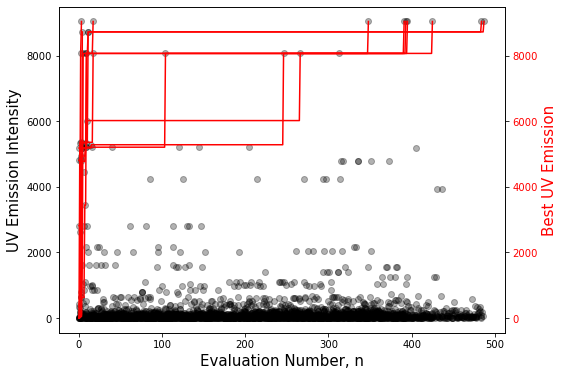

iterations to the max UV: 295.7+/-191.92240619583737


In [72]:
import matplotlib.pyplot as plt
from botorch.acquisition import UpperConfidenceBound

    
plt.figure(0)
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

max_x = 0
max_y = 0
steps = []
UVs=[]
#for i in [9]:
for i in range(len(log_seed)):
    max_xi, max_yi = add_one_ensemble(log_seed,i)
    steps.append(max_xi)
    UVs.append(max_yi)
    max_x = max(max_xi,max_x)
    max_y = max(max_yi,max_y)

FontSize = 15
ax1.set_ylim(-max_y*0.05,max_y*1.05)
ax2.set_ylim(-max_y*0.05,max_y*1.05)
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission', color='r', fontsize = FontSize)
plt.setp(ax2.get_yticklabels(), color="red")
# plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
# plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([-max_x*0.05,max_x*1.05])
    
plt.show()
print(f'iterations to the max UV: {np.mean(steps)}+/-{np.std(steps)}')

In [16]:
beta

100

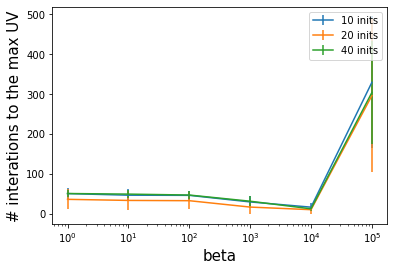

In [76]:
import matplotlib.pyplot as plt
import pickle
beta_list = [1,10,100,1000,10000,1e5]
    
df0 = pickle.load( open( "pool_based_tuning/log_result_20inits_10trials_beta=1_2.pkl", "rb" ) )
df1 = pickle.load( open( "pool_based_tuning/log_result_20inits_10trials_beta=10_2.pkl", "rb" ) )
df2 = pickle.load( open( "pool_based_tuning/log_result_20inits_10trials_beta=100_2.pkl", "rb" ) )
df3 = pickle.load( open( "pool_based_tuning/log_result_20inits_10trials_beta=1000_2.pkl", "rb" ) )
df4 = pickle.load( open( "pool_based_tuning/log_result_20inits_10trials_beta=1e4_2.pkl", "rb" ) )
df5 = pickle.load( open( "pool_based_tuning/log_result_20inits_10trials_beta=1e5_2.pkl", "rb" ) )
#df6 = pickle.load( open( "pool_based_tuning/log_result_20inits_10trials_beta=1e6.pkl", "rb" ) )

df10_0 = pickle.load( open( "pool_based_tuning/log_result_10inits_10trials_beta=1.pkl", "rb" ) )
df10_1 = pickle.load( open( "pool_based_tuning/log_result_10inits_10trials_beta=10.pkl", "rb" ) )
df10_2 = pickle.load( open( "pool_based_tuning/log_result_10inits_10trials_beta=100.pkl", "rb" ) )
df10_3 = pickle.load( open( "pool_based_tuning/log_result_10inits_10trials_beta=1000.pkl", "rb" ) )
df10_4 = pickle.load( open( "pool_based_tuning/log_result_10inits_10trials_beta=1e4.pkl", "rb" ) )
df10_5 = pickle.load( open( "pool_based_tuning/log_result_10inits_10trials_beta=1e5.pkl", "rb" ) )

df40_0 = pickle.load( open( "pool_based_tuning/log_result_40inits_10trials_beta=1.pkl", "rb" ) )
df40_1 = pickle.load( open( "pool_based_tuning/log_result_40inits_10trials_beta=10.pkl", "rb" ) )
df40_2 = pickle.load( open( "pool_based_tuning/log_result_40inits_10trials_beta=100.pkl", "rb" ) )
df40_3 = pickle.load( open( "pool_based_tuning/log_result_40inits_10trials_beta=1000.pkl", "rb" ) )
df40_4 = pickle.load( open( "pool_based_tuning/log_result_40inits_10trials_beta=1e4.pkl", "rb" ) )
df40_5 = pickle.load( open( "pool_based_tuning/log_result_40inits_10trials_beta=1e5.pkl", "rb" ) )

def get_stats(df_all):
    step_mean = []
    step_std = []
    for dfi in df_all:
        max_x = 0
        max_y = 0
        steps = []
        UVs=[]
        #for i in [9]:
        for i in range(len(dfi)):
            max_xi, max_yi = add_one_ensemble(dfi,i)
            steps.append(max_xi)
            UVs.append(max_yi)
            max_x = max(max_xi,max_x)
            max_y = max(max_yi,max_x)

        step_mean.append(np.mean(steps))
        step_std.append(np.std(steps))
    return step_mean, step_std

df_all_20inits = [df0,df1,df2,df3,df4,df5]
mean_20inits, std_20inits = get_stats(df_all_20inits)
df_all_10inits = [df10_0,df10_1,df10_2,df10_3,df10_4,df10_5]
mean_10inits, std_10inits = get_stats(df_all_10inits)
df_all_40inits = [df40_0,df40_1,df40_2,df40_3,df40_4,df40_5]
mean_40inits, std_40inits = get_stats(df_all_40inits)

FontSize = 15

plt.xlabel('beta', fontsize = FontSize)
plt.ylabel('# interations to the max UV', fontsize = FontSize)

plt.errorbar(beta_list, mean_10inits, std_10inits, label = '10 inits')
plt.errorbar(beta_list, mean_20inits, std_20inits, label = '20 inits')
plt.errorbar(beta_list, mean_40inits, std_40inits, label = '40 inits')
plt.xscale('log')    
#plt.yscale('log')    
  
plt.legend()
plt.show()


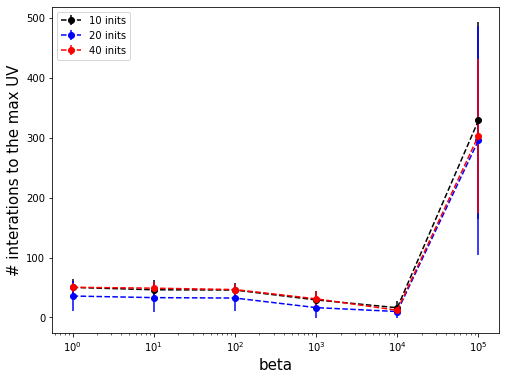

In [86]:
FontSize = 15
fig, ax1 = plt.subplots(figsize=(8, 6))
plt.xlabel('beta', fontsize = FontSize)
plt.ylabel('# interations to the max UV', fontsize = FontSize)

plt.errorbar(beta_list, mean_10inits, std_10inits, label = '10 inits', c='black', marker='o',linestyle='dashed')
plt.errorbar(beta_list, mean_20inits, std_20inits, label = '20 inits', c='b',marker='o',linestyle='dashed')
plt.errorbar(beta_list, mean_40inits, std_40inits, label = '40 inits', c='red',marker='o',linestyle='dashed')
plt.xscale('log')    

plt.legend(loc='upper left')
plt.show()